In [1]:
# Download data file.
from astroquery.mast import Observations

obs_table = Observations.query_criteria(
    dataproduct_type=["image"],
    filters='F150W',
    instrument_name='NIRCAM/IMAGE',
    objectname='M92'
)

products = Observations.get_product_list(
    obs_table
)

filters = Observations.filter_products(
    products=products,
    productType=["SCIENCE"],
    extension="fits",
    productSubGroupDescription='I2D',
    mrp_only=True

)

result = Observations.download_products(
    products=filters,
    cache=True,
    mrp_only=True,
    flat=True
)

# Finding Stars using DAOStarFinder

In [2]:
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from photutils.detection import DAOStarFinder

In [3]:
neb_data = fits.open("jw01334-o001_t001_nircam_clear-f150w_i2d.fits")

In [4]:
neb_data.info()

Filename: jw01334-o001_t001_nircam_clear-f150w_i2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     379   ()      
  1  SCI           1 ImageHDU        75   (9895, 4397)   float32   
  2  ERR           1 ImageHDU        10   (9895, 4397)   float32   
  3  CON           1 ImageHDU        10   (9895, 4397, 1)   int32   
  4  WHT           1 ImageHDU         9   (9895, 4397)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (9895, 4397)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (9895, 4397)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (9895, 4397)   float32   
  8  HDRTAB        1 BinTableHDU    836   32R x 413C   [23A, 5A, 3A, 45A, 7A, 13A, 5A, 5A, 6A, 7A, 10A, 4A, L, D, D, D, D, 32A, 50A, 62A, 16A, 3A, D, 19A, D, 10A, 12A, 23A, 23A, 26A, 11A, 5A, 3A, 3A, 2A, 1A, 2A, 1A, L, 14A, 3A, 2A, 26A, 20A, 27A, 10A, K, L, L, L, L, 3A, 3A, 5A, D, D, D, D, D, D, D, D, D, D, 6A, 5A, 1A, 5A, 5A, 5A, L, D, D, D, D, D, D,

(4397, 9895)


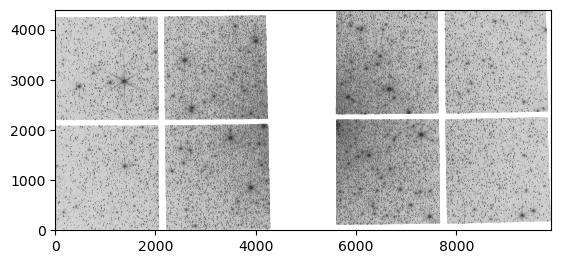

In [5]:
img_data = neb_data[1].data
print(img_data.shape)
plt.imshow(img_data, origin = "lower", cmap = "Greys", norm = LogNorm() )
plt.show()

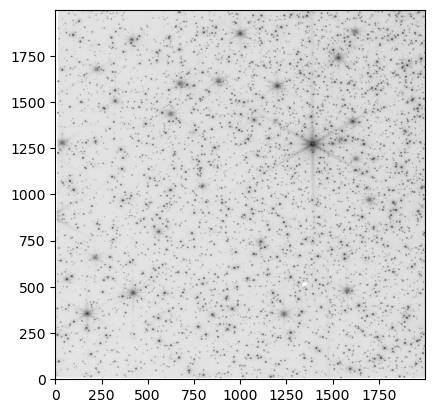

In [6]:
focused = img_data[0:2000, 0:2000]
plt.imshow(focused, origin = "lower", cmap = "Greys", norm = LogNorm())
plt.show()


In [7]:
mean, median, std = sigma_clipped_stats(focused, sigma= 4.0)
print(mean, median, std)

0.3520839 0.30564916 0.15697701


In [8]:
daofind = DAOStarFinder(fwhm=1.613, threshold= 98*std, exclude_border=True)#The full-width half-maximum (FWHM)
sources = daofind(focused)
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float32,float64,int64,float64,float64,float64,float64
1,1545.9309871988373,7.5994295703893355,0.7680752119370835,-0.19107303,-0.2260378074852919,25,0.0,50.47392654418945,2.9523978233337402,-1.1754371911751946
2,895.5922052326216,7.846180968028361,0.6863071706396662,-0.24383257,-0.07626580403305296,25,0.0,22.083017349243164,1.176032304763794,-0.1760481291546341
3,1888.0148958167829,11.455974475261302,0.7504961796600704,0.122492604,0.13290776238374297,25,0.0,78.54415893554688,4.706633567810059,-1.6817759697027748
4,1015.5953994671335,13.342803280130367,0.7226484830873239,0.8397838,-0.3381170913121916,25,0.0,27.250627517700195,1.2543971538543701,-0.2460876498888066
5,1165.6094356376805,12.530138167447351,0.7256726774376762,0.44118506,0.20853906297202396,25,0.0,467.043701171875,28.135360717773438,-3.6231312188187097
6,1696.607189908458,12.840817913734972,0.7121618877064022,0.21990572,0.09062236007541599,25,0.0,25.325902938842773,1.4519237279891968,-0.40485950684778427
7,159.19224134791529,13.80231182979679,0.7141580221276722,0.049687397,0.15913624274405566,25,0.0,29.170454025268555,1.6323944330215454,-0.5320627625574414
8,1862.6217086327338,13.755808967872714,0.7302431345119428,0.21591587,-0.10773540149725774,25,0.0,193.60877990722656,11.367531776428223,-2.6391654422287436
9,194.71611146935163,14.858364439308145,0.7524659623094371,-0.01063868,-0.11264683354007647,25,0.0,43.482975006103516,2.1862754821777344,-0.8492622111106941


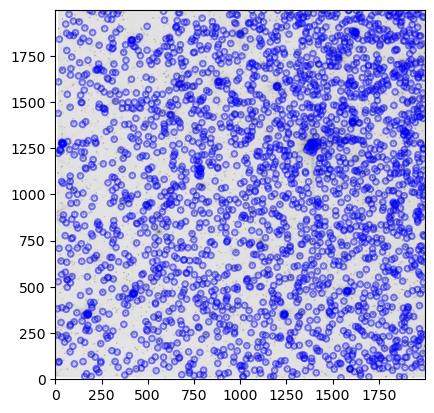

In [9]:
from photutils.aperture import CircularAperture
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
# print(positions)
apertures = CircularAperture(positions, r = 15.0)
plt.imshow(focused, cmap = 'Greys', origin = "lower", norm = LogNorm())
apertures.plot(color = 'blue', lw = 1.5, alpha = 0.5);
plt.show()

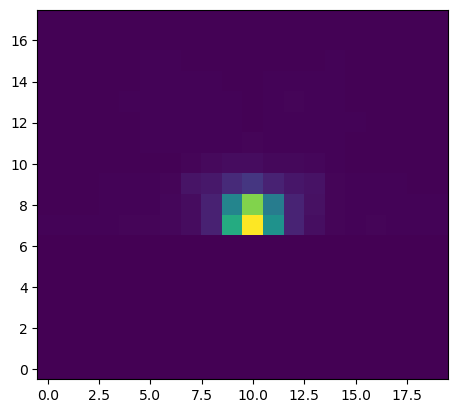

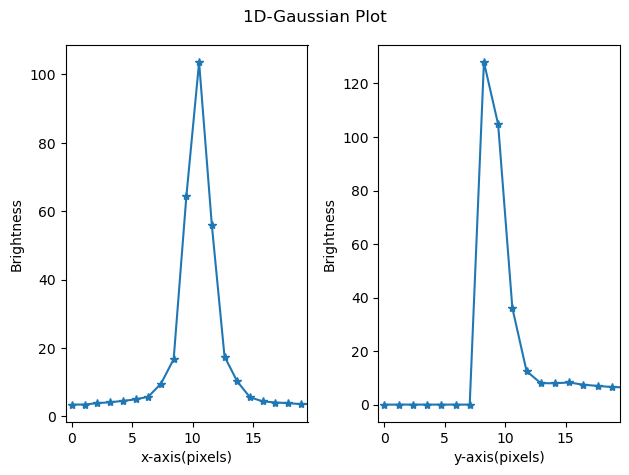

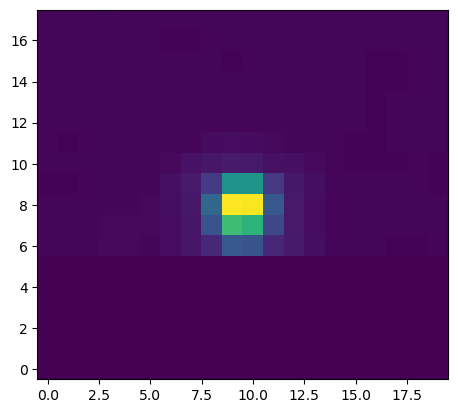

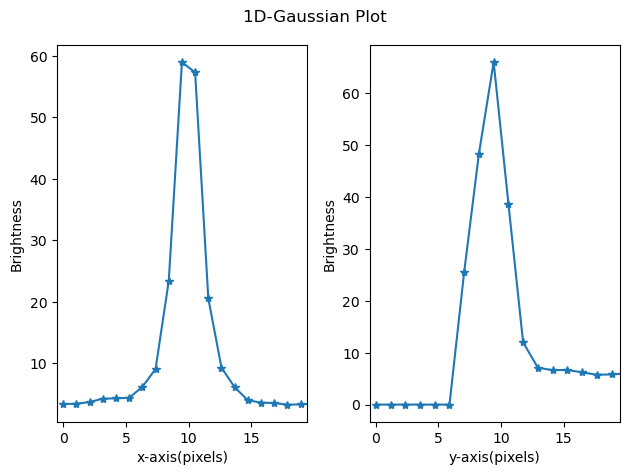

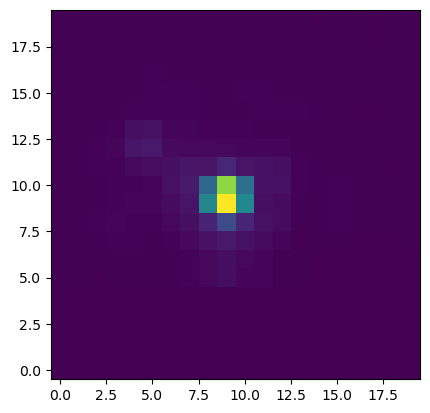

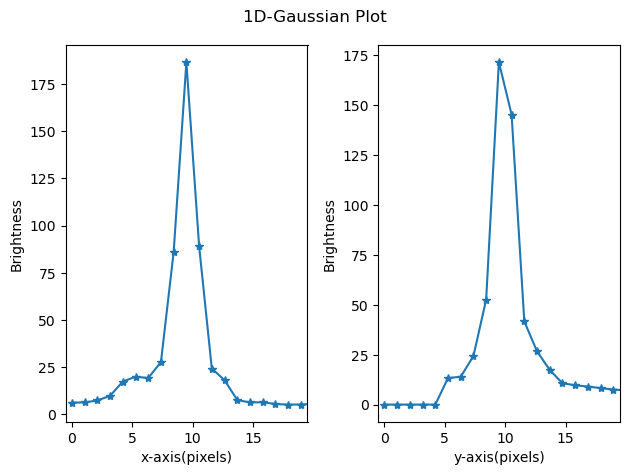

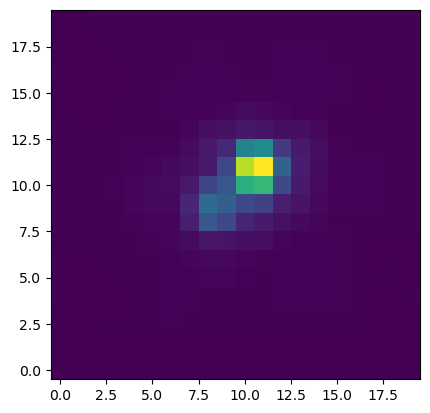

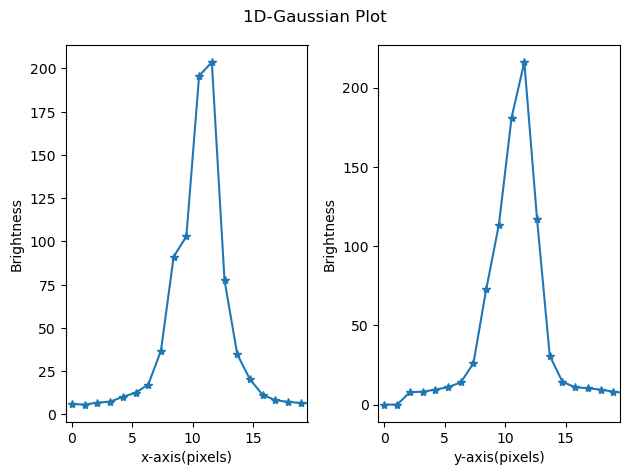

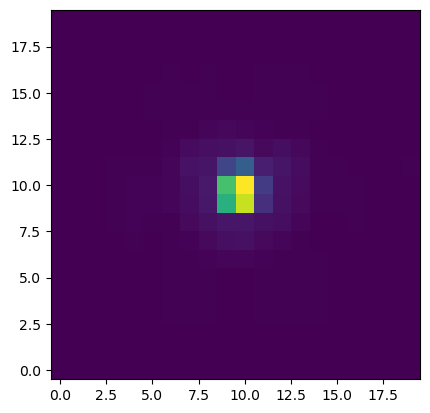

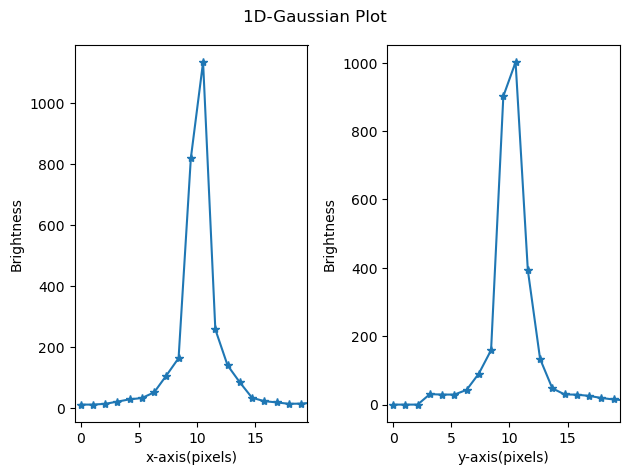

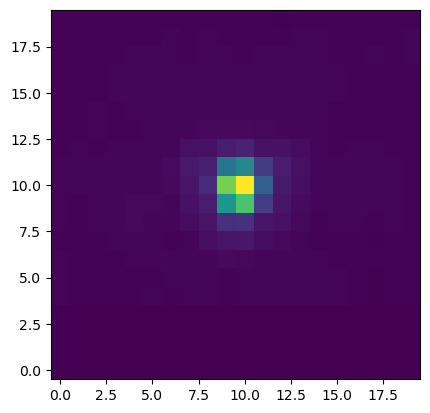

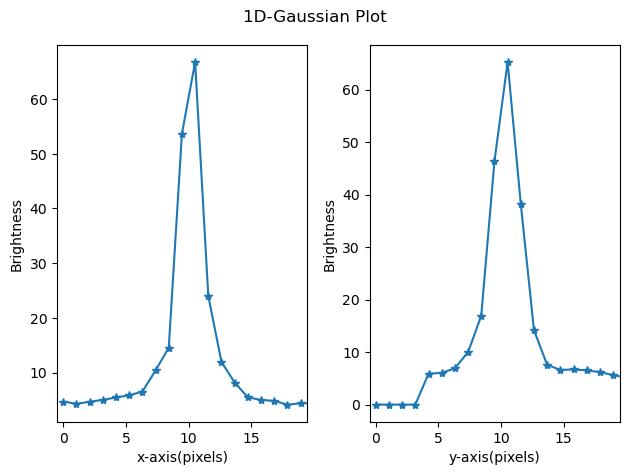

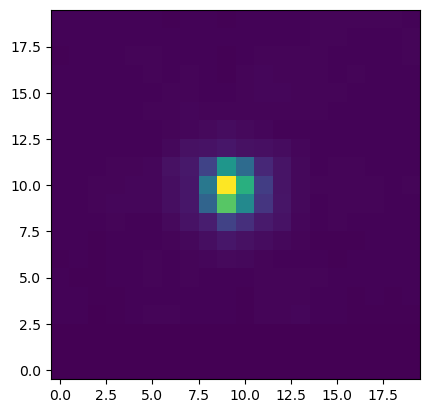

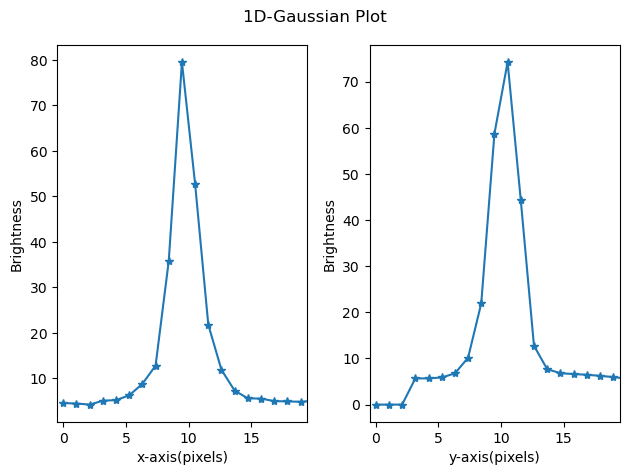

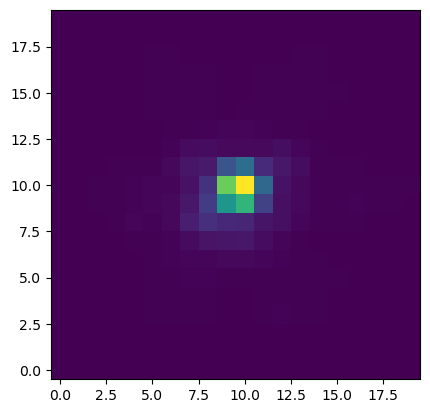

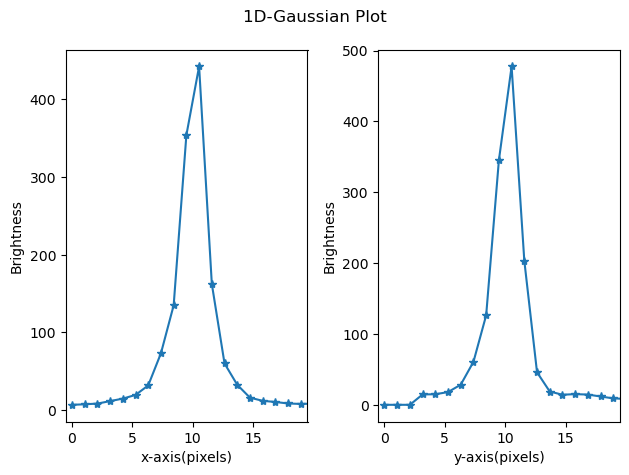

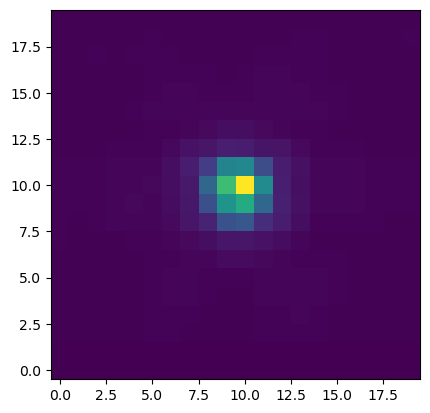

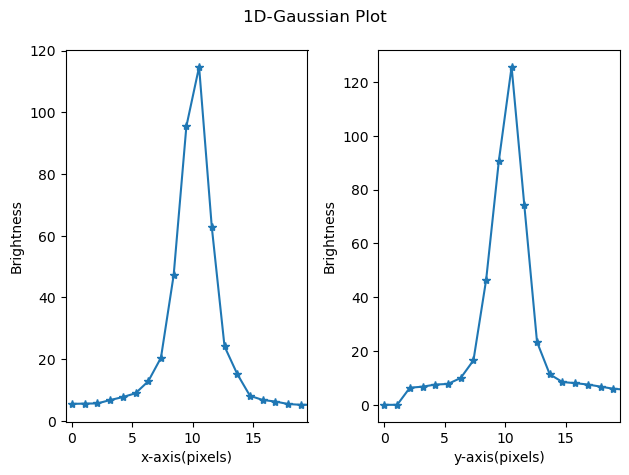

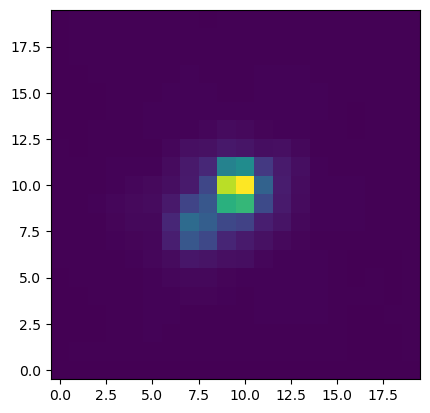

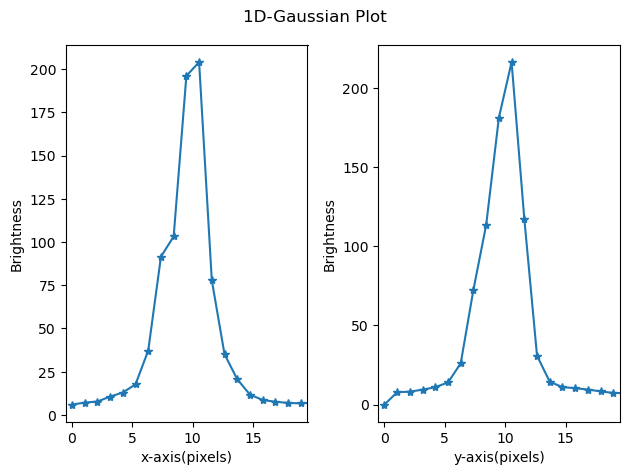

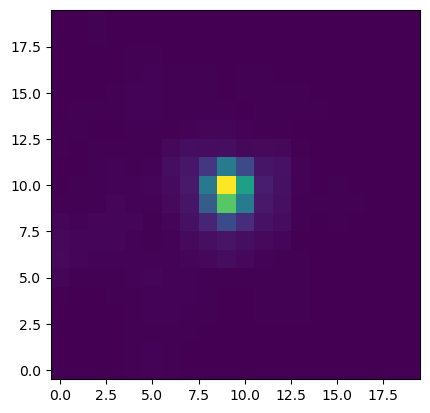

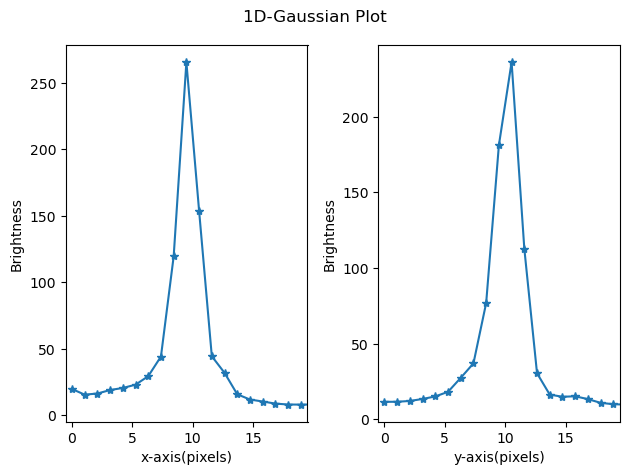

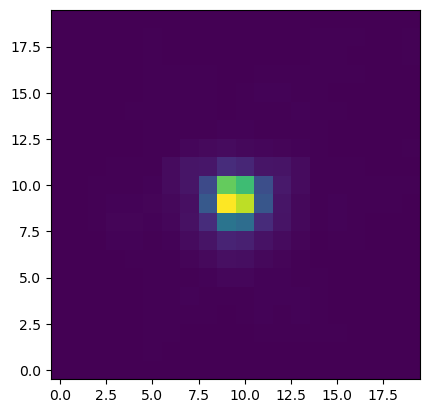

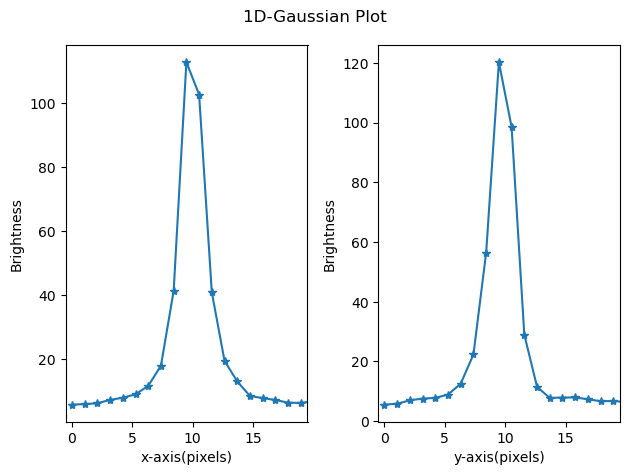

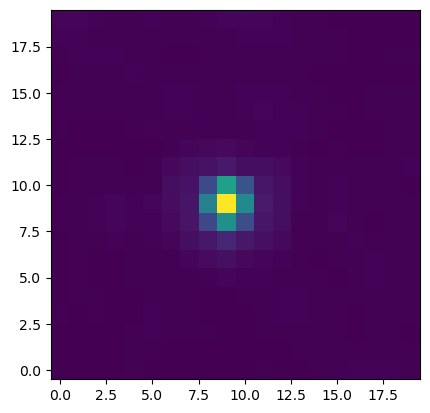

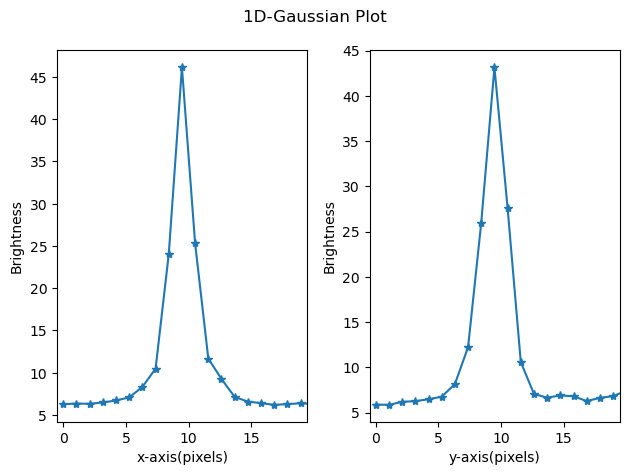

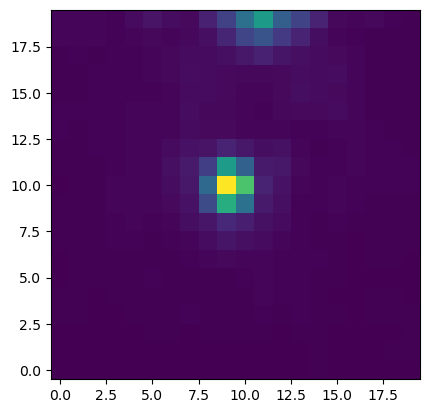

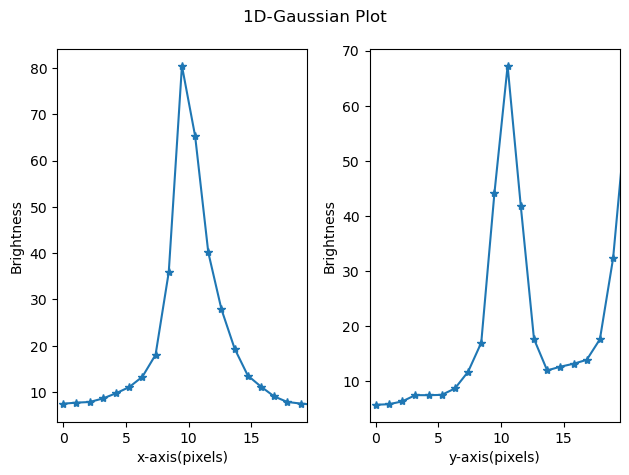

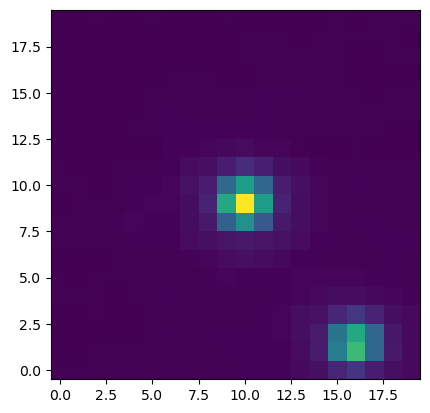

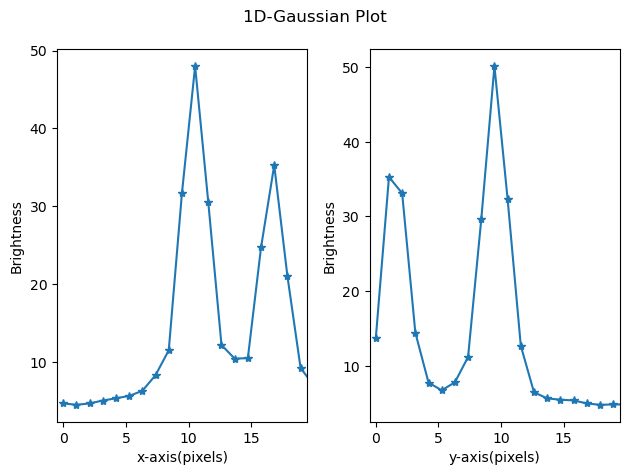

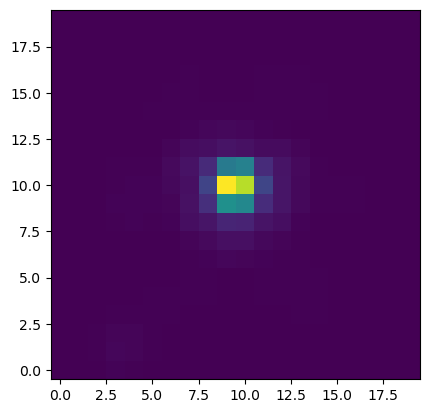

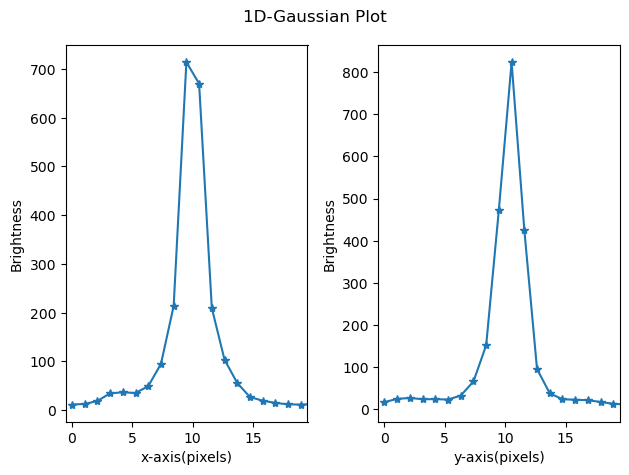

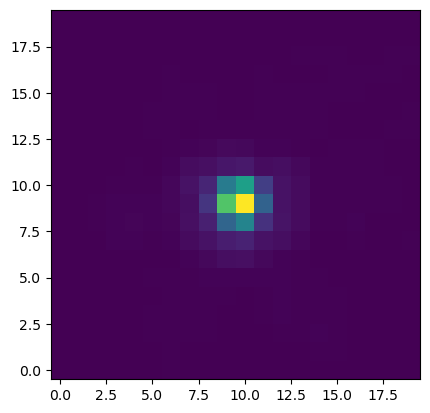

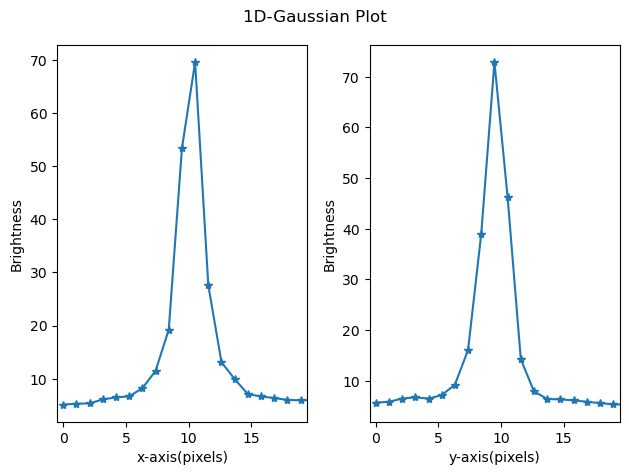

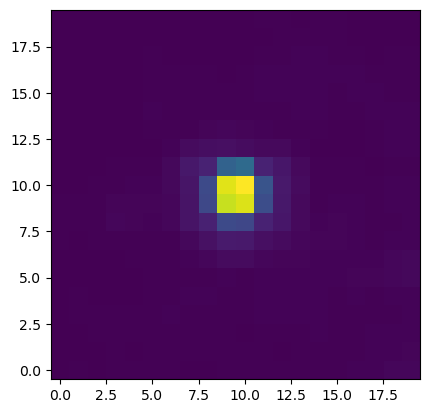

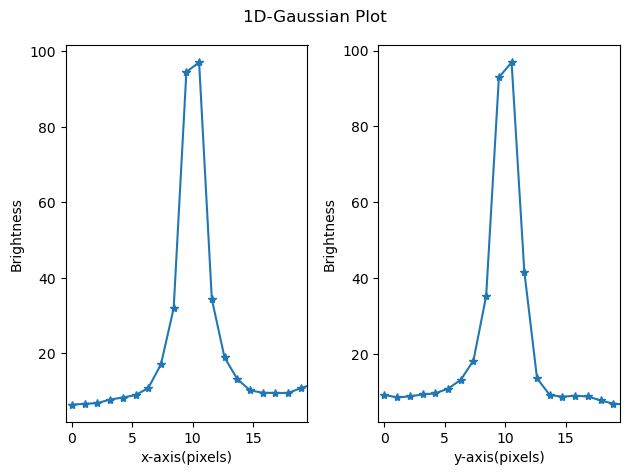

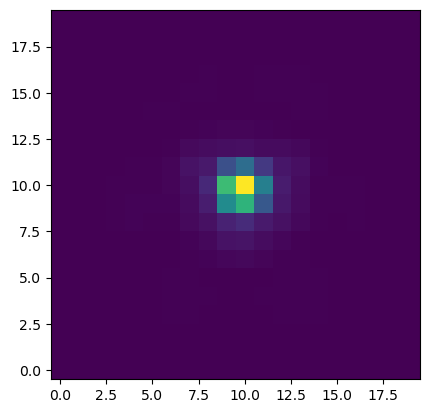

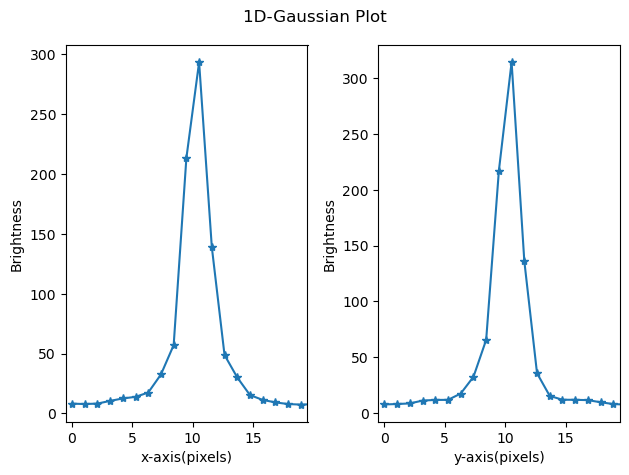

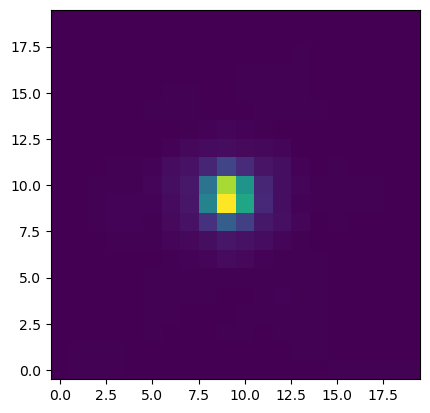

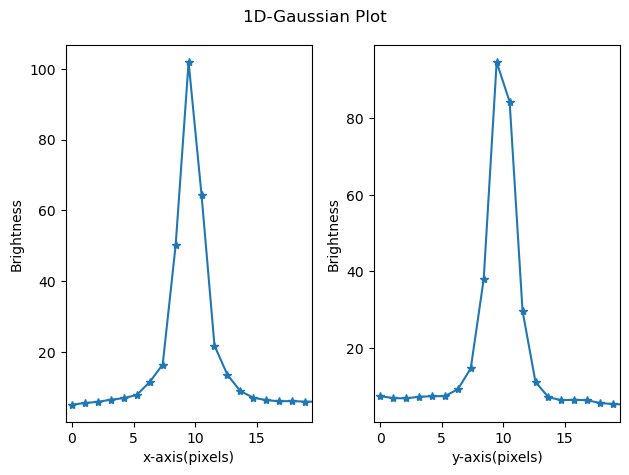

In [10]:
from astropy.nddata import Cutout2D
count = 0
for x, y in zip(sources['xcentroid'], sources['ycentroid']):
    if count == 20:
        break
    count += 1
    cutout1 = Cutout2D(focused, (x, y), 20)
    # print(cutout1.data)
    # print(cutout1.data.shape)
    # break
    plt.imshow(cutout1.data, origin='lower')
    # left, right = plt.xlim()  
    # print(left,right)
    plt.show()
    # break


    x_pixels = np.sum(cutout1.data, axis = 0)
    y_pixels = np.sum(cutout1.data, axis = 1)
    a = np.linspace(0, cutout1.data.shape[1], y_pixels.shape[0])
    b = np.linspace(0, cutout1.data.shape[1], x_pixels.shape[0])
    # print(y_pixels,y_pixels.shape,a.shape)
    # break
    # print(a)
    # a = np.linspace(0, cutout1.data.shape[1])
    # print(a)
    plt.subplot(1,2,1)
    # # print(cutout1.data)
    # print(np.sum(cutout1.data, axis = 1))
    plt.plot(b,x_pixels, label = "", marker ="*")
    plt.xlim(-0.5,19.5)
    # break
    plt.xlabel("x-axis(pixels)")
    plt.ylabel("Brightness")
    plt.subplot(1,2,2)
    plt.plot(a,y_pixels, marker = "*")   # break
    plt.xlim(-0.5,19.5)
    plt.suptitle("1D-Gaussian Plot")
    plt.xlabel("y-axis(pixels)")
    plt.ylabel("Brightness")
    plt.tight_layout()
    plt.show()
    
